# Hyperparameter Optimisation Lab - 1

## Building models with Gaussians

In this section we'll consider using the Gaussian Distribution to model an arbitrary dataset.

$$p(x | \pi, \Sigma) = (2\pi)^{k/2}|\Sigma|^{-1/2}\text{exp}\Bigl\{ -\frac{1}{2} (x-\mu)^{\prime} \Sigma^{-1} (x-\mu)\Bigr\}$$

Why would we like to do this? There would not seem to be any gain in doing it, because normal distributions are not particularly flexible distributions in and of themselves. However, adopting a set of Gaussians (a multivariate normal vector) confers a number of advantages. First, the marginal distribution of any subset of elements from a multivariate normal distribution is also normal:

$$ p(x,y) = \mathcal{N} \biggl( \begin{bmatrix}
                                   \mu_{x} \\
                                   \mu_{y} \\
                                \end{bmatrix},
                                \begin{bmatrix}
                                   \Sigma_x, \Sigma_{xy} \\
                                   \Sigma_{xy}^T, \Sigma_y \\
                                \end{bmatrix}
\biggr) $$

$$
    p(x) = \int p(x,y) dy = \mathcal{N} (\mu_x, \Sigma_x)
$$

Also, conditional distributions of a subset of the elements of a multivariate normal distribution (conditional on the remaining elements) are normal too:

$$
p(x|y) = \mathcal{N} (\mu_x + \Sigma_{xy} \Sigma^{-1}_y (y - \mu_y), \Sigma_x - \Sigma_{xy} \Sigma^{-1}_y \Sigma_{xy}^T)
$$

A Gaussian process generalizes the multivariate normal to infinite dimension. It is defined as an infinite collection of random variables, with any marginal subset having a Gaussian distribution. Thus, the marginalization property is explicit in its definition. Another way of thinking about an infinite vector is as a function. When we write a function that takes continuous values as inputs, we are essentially implying an infinite vector that only returns values (indexed by the inputs) when the function is called upon to do so. By the same token, this notion of an infinite-dimensional Gaussian represented as a function allows us to work with them computationally: we are never required to store all the elements of the Gaussian process, only to calculate them on demand.

So, we can describe a Gaussian process as a **distribution over functions**. Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a GP is fully specified by a mean function and a covariance function:

$$p(x) \sim \text{GP} (m(x), k(x, y))$$

It is the marginalization property that makes working with a Gaussian process feasible: we can marginalize over the infinitely-many variables that we are not interested in, or have not observed.

For example, one specification of a GP might be:

$$ 
\begin{align}
m(x) &= 0 \\
k(x, y) &= \theta_1 \text{exp} \biggl( \frac{\theta_2}{2} (x-y)^2 \biggr)
\end{align}
$$

Here, the covariance function is a squared exponential, for which values of $x$ and $y$ that are close together result in values of $k$ closer to one, while those that are far apart return values closer to zero. It may seem odd to simply adopt the zero function to represent the mean function of the Gaussian process — surely we can do better than that! It turns out that most of the learning in the GP involves the covariance function and its hyperparameters, so very little is gained in specifying a complicated mean function.

For a finite number of points, the GP becomes a multivariate normal, with the mean and covariance as the mean function and covariance function, respectively, evaluated at those points.

## Sampling from a Gaussian Process

To make this notion of a "distribution over functions" more concrete, let's quickly demonstrate how we obtain realizations from a Gaussian process, which results in an evaluation of a function over a set of points. All we will do here is a sample from the prior Gaussian process, so before any data have been introduced. What we need first is our covariance function, which will be the squared exponential, and a function to evaluate the covariance at given points (resulting in a covariance matrix).


In [1]:
import numpy as np
import matplotlib.pylab as plt

def exponential_cov(x, y, theta):
    return theta[0] * np.exp( -0.5 * theta[1] * np.subtract.outer(x, y)**2)

We are going generate realizations sequentially, point by point, using the lovely conditioning property of mutlivariate Gaussian distributions. Here is that conditional:

$$p(x,y) = \mathcal{N} (\mu_x + \Sigma_{xy} \Sigma^{-1}_y (y - \mu_y), \Sigma_x - \Sigma_{xy} \Sigma^{-1}_y \Sigma_{xy}^T)$$

### Task 1

Write a function *conditional(x_new, x, y, params)* that calculates $\mu$ and $\Sigma$ using the formula above. 

Hint: $\Sigma_{x}$, $\Sigma_{y}$, and $\Sigma_{xy}$ are already calculated for you.

In [2]:
def conditional(x_new, x, y, params):
    
    Sigma_xy = exponential_cov(x_new, x, params)
    Sigma_y = exponential_cov(x, x, params)
    Sigma_x = exponential_cov(x_new, x_new, params)
    
    mu = np.linalg.inv(Sigma_y).dot(Sigma_xy.T).T.dot(y)
    sigma = Sigma_x - Sigma_xy.dot(np.linalg.inv(Sigma_y).dot(Sigma_xy.T))         
    
    return(mu.squeeze(), sigma.squeeze())

We will start with a Gaussian process prior with hyperparameters $\sigma_0=1$, $\sigma_2=10$. We will also assume a zero function as the mean, so we can plot a band that represents one standard deviation from the mean.


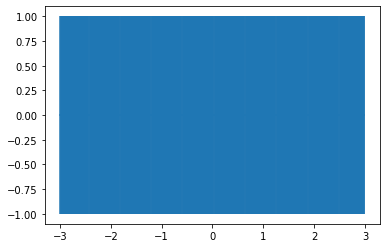

In [3]:
θ = [1, 10]
σ_0 = exponential_cov(0, 0, θ)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=σ_0, capsize=0);

Let's select an arbitrary starting point to sample, say $x=1$. Since there are no previous points, we can sample from an unconditional Gaussian:

In [4]:
x = [1.]
y = [np.random.normal(scale=σ_0)]
print(y)

[1.577986635648452]


We can now update our confidence band, given the point that we just sampled, using the covariance function to generate new point-wise intervals, conditional on the value [$x_0$, $y_0$].

In [5]:
σ_1 = exponential_cov(x, x, θ)

def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, θ, σ_1, y) for i in x_pred]

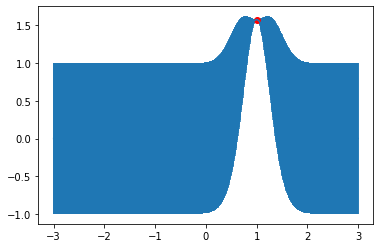

In [6]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro");

So conditional on this point, and the covariance structure we have specified, we have essentially constrained the probable location of additional points. Let's now sample another:

In [7]:
m, s = conditional([-0.7], x, y, θ)
y2 = np.random.normal(m, s)
print(y2)

-1.8143473276322344


This point is added to the realization, and can be used to further update the location of the next point.

In [8]:
x.append(-0.7)
y.append(y2)
σ_2 = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_2, y) for i in x_pred]

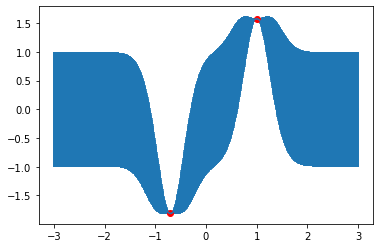

In [9]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro");

Of course, sampling sequentially is just a heuristic to demonstrate how the covariance structure works. We can just as easily sample several points at once:

In [10]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, θ)
y_more = np.random.multivariate_normal(mu, s)
print(y_more)

[-0.82756021 -0.1233382   0.83636461 -0.40694234  0.02370529]


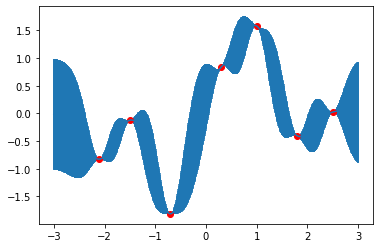

In [11]:
x += x_more
y += y_more.tolist()
σ_new = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_new, y) for i in x_pred]
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro");

So as the density of points becomes high, it results in a realization (sample function) from the prior GP.

## Fitting Gaussian Processes using scikit-learn

Though it's entirely possible to extend the code above to introduce data and fit a Gaussian process by hand, there are a number of libraries available for specifying and fitting GP models in a more automated way. I will demonstrate and compare three packages that include classes and functions specifically tailored for GP modeling:

* [scikit-learn](http://scikit-learn.org/stable/modules/gaussian_process.html)
* [GPflow](https://github.com/GPflow/GPflow)
* [PyMC3](https://docs.pymc.io/en/stable/)

In particular, each of these packages includes a set of covariance functions that can be flexibly combined to adequately describe the patterns of non-linearity in the data, along with methods for fitting the parameters of the GP.

Let's see how fitting a Gaussian process using scikit-learn works. First, let's generate some random data. 

In [16]:
def corr_vars( start=1, stop=10, step=1, mu=7, sigma=2, func=lambda x: x ):

    # Generate x
    x = np.arange(start, stop, step)  
    
    # Generate random noise
    e = np.random.normal(mu, sigma, x.size)
    
    # Generate y values as y = func(x) + e
    y = np.zeros(x.size)
    
    for ind in range(x.size):
        y[ind] = func(x[ind]) + e[ind]
    
    return (x,y)

Notice, that we aren't adding noise to our *X* and *y* variables. Feel free to experiment later by injecting some noise (set *mu* and *sigma* to non-zero values) and see how the GP fitting process responds.

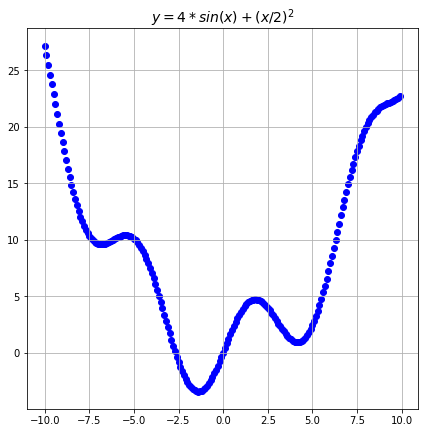

In [17]:
(X,y) = corr_vars(-10, 10, .1, 0, 0, lambda x: 4*np.sin(x) + pow(0.5*x,2))
X = X.reshape(-1, 1)

f, ax = plt.subplots(1, 1, figsize=(7,7))
ax.scatter(X, y, color="blue")       

ax.set_title(r"$y = 4 * sin(x) + (x/2)^2$", fontsize=14)
ax.grid(True)

We have our data, now let's see what scikit-learn has to offer.

For regression tasks, where we are predicting a continuous response variable, a [GaussianProcessRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html) is applied by specifying an appropriate covariance function, or **kernel**. Fitting proceeds by maximizing the log of the marginal likelihood, a convenient approach for Gaussian processes that avoids the computationally-intensive cross-validation strategy that is usually employed in choosing optimal hyperparameters for the model. The GaussianProcessRegressor does not allow for the specification of the mean function, always assuming it to be the zero function, highlighting the diminished role of the mean function in calculating the posterior.

Now, let's sample some observations from our dataset and see how we can use them to model our data. The number of samples drawn from our dataset is controlled by the *sample_size* variable.

In [18]:
sample_size = 3

rng = np.random.RandomState(1234)
training_indices = rng.choice(np.arange(y.size), size=sample_size, replace=False)

X_train = X[training_indices]
y_train = y[training_indices]

scikit-learn offers a library of about a dozen covariance functions, which they call kernels, to choose from.

Here we will use a [Radial Basis Function kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html) (aka squared-exponential kernel). The RBF kernel is a stationary kernel. It is also known as the "squared exponential" kernel. It is parameterized by a length scale parameter $l>0$, which can either be a scalar or a vector with the same number of dimensions as the inputs X. The kernel is given by:

$$k(x, y) = \text{exp} \biggl( -\frac{d(x,y)^2}{2l^2} \biggr) $$
 
where $l$ is the length scale of the kernel and $d(.,.)$ is the Euclidean distance.

Note, that the kernel hyperparameters are optimized during fitting unless the bounds are marked as "fixed".

Your task here is to define an RBF kernel with $l=1.0$ with a lower and upper bound of $1×10^{-1}$ and $1×10^{2}$ respectively.


### Task 2

Define the RBF kernel and fit the GP below.

In [28]:
from sklearn import gaussian_process

# Define an RBF kernel
kernel = gaussian_process.kernels.RBF(length_scale=2.0, length_scale_bounds=(1e-1, 1e1))


# Set up a Gaussian process
gp = gaussian_process.GaussianProcessRegressor(random_state=1234, kernel=kernel)

# Fit the model
gp.fit(X_train, y_train)

GaussianProcessRegressor(kernel=RBF(length_scale=2), random_state=1234)

The fit method endows the returned model object with attributes associated with the fitting procedure; these attributes will all have an underscore (\_) appended to their names. For example, the kernel_ attribute will return the kernel used to parameterize the GP, along with their corresponding optimal hyperparameter values:

In [29]:
gp.kernel_

RBF(length_scale=2.45)

Along with the fit method, each supervised learning class retains a predict method that generates predicted outcomes ($y^{\ast}$) given a new set of predictors ($X^{\ast}$) distinct from those used to fit the model. For a Gaussian process, this is fulfilled by the posterior predictive distribution, which is the Gaussian process with the mean and covariance functions updated to their posterior forms, after having been fit.

$$ p(y^{\ast}|y, x, x^{\ast}) = \text{GP} (m^{\ast}(x^{\ast}), k^{\ast}(x^{\ast})) $$

Notice that we can calculate a prediction for arbitrary inputs $X^*$. To get a sense of the form of the posterior over a range of likely inputs, we can pass it a linear space as we have done above. *predict* optionally returns posterior standard deviations along with the expected value, so we can use this to plot a confidence region around the expected function.

In [30]:
x_pred = np.linspace(-10, 10, num=200).reshape(-1,1)
y_pred, sigmas = gp.predict(x_pred, return_std=True)

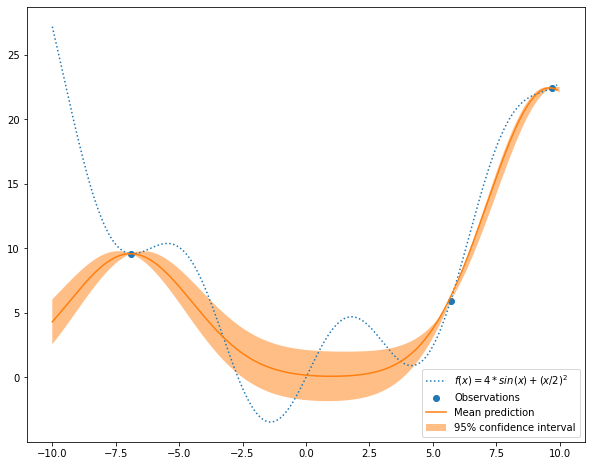

In [31]:
plt.figure(figsize=(10, 8))
plt.plot(X, y, label=r"$f(x) = 4 * sin(x) + (x/2)^2$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, y_pred, label="Mean prediction")
plt.fill_between(
    x_pred.ravel(),
    y_pred - 1.95 * sigmas,
    y_pred + 1.95 * sigmas,
    alpha=0.5,
    label="95% confidence interval"
)
plt.legend(loc = "lower right");

### Task 3 [Optional]

Try different values for *sample_size*, re-fit the model and observe how the predictions/confidence changes.